In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from shapely.geometry import Point, Polygon
import numpy as np
from skimage import io
import statsmodels.api as sm
import glob
import json


os.environ["NAMESPACE"]="research"
os.environ["PROFILE"]="local"
from agrobrain_util.runtime.evironment import RuntimeEnv

DATA_DIR = "data"
env = RuntimeEnv()

import dtlpy as dl
if dl.token_expired():
    dl.login()

project = dl.projects.get(project_name='Taranis AI Annotation Projects')


csv_path = os.path.join(DATA_DIR, "resolution_limitation_tags_dataframe_2.csv")
resolution_tags_df = pd.read_csv(csv_path)

images_data = pd.read_csv(os.path.join(DATA_DIR, 'resolution_test', 'resolution_test_images_dataframe_1000_images_full_data_1.csv'))
images_data = images_data[~images_data['wideImageID'].isna()].reset_index(drop=True)


resolution_tags_df['original_polygons_avg_area_m2'] = resolution_tags_df['original_polygons_avg_area_mm2'] / 1000000
resolution_tags_df['poly_union_area_m2'] = resolution_tags_df['poly_union_area_mm2'] / 1000000
resolution_tags_df['poly_box_area_m2'] = resolution_tags_df['poly_box_area_mm2'] / 1000000

resolution_tags_df['original_polygons_avg_area_cm2'] = resolution_tags_df['original_polygons_avg_area_mm2'] / 100
resolution_tags_df['poly_union_area_cm2'] = resolution_tags_df['poly_union_area_mm2'] / 100
resolution_tags_df['poly_box_area_cm2'] = resolution_tags_df['poly_box_area_mm2'] / 100


resolution_tags_df_sorted = resolution_tags_df.sort_values(by='poly_union_area_pixel')

resolution_tags_df_sorted['res_7.2_binary'] = resolution_tags_df_sorted['res_7.2'].apply(lambda x: 1 if x > 0 else 0)
resolution_tags_df_sorted['res_9.0_binary'] = resolution_tags_df_sorted['res_9.0'].apply(lambda x: 1 if x > 0 else 0)
resolution_tags_df_sorted['res_10.8_binary'] = resolution_tags_df_sorted['res_10.8'].apply(lambda x: 1 if x > 0 else 0)
resolution_tags_df_sorted['res_12.6_binary'] = resolution_tags_df_sorted['res_12.6'].apply(lambda x: 1 if x > 0 else 0)
resolution_tags_df_sorted['res_14.4_binary'] = resolution_tags_df_sorted['res_14.4'].apply(lambda x: 1 if x > 0 else 0)




example_image_id = int(resolution_tags_df_sorted['image_id'][0])
im_path = env.download_image(int(example_image_id))
example_image = io.imread(im_path)
example_image_shape = example_image.shape
image_area_pixels = example_image_shape[0] * example_image_shape[1]
original_image_width = example_image_shape[1]
original_image_height = example_image_shape[0]




could not find stamp in environment variables
could not find stamp in environment variables
could not find KUBEFLOW_API_BASIC_AUTH_TOKEN in environment variables
could not find AI_RABBITMQ_CONNECTION_STRING in environment variables
could not find AI_MONGO_DB_CONNECTION_STRING in environment variables
could not find TARANIS_DB_CONNECTION_STRING in environment variables
could not find GLOBAL_DB_CONNECTION_STRING in environment variables
could not find AI_MONGO_DB_CONNECTION_STRING_NEW in environment variables
/usr/local/lib/python3.8/dist-packages/skimage/io/_plugins/imageio_plugin.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  return np.asarray(imageio_imread(*args, **kwargs))


In [94]:
resolution_tags_df_sorted.columns

Index(['Unnamed: 0', 'original_polygons', 'poly_intersection',
       'overlapping_polygons_indexes', 'original_polygons_avg_area_pixel',
       'original_polygons_avg_length_mm', 'original_polygons_avg_area_mm2',
       'num_of_original_polygons', 'poly_union', 'poly_union_area_pixel',
       'poly_union_length_mm', 'poly_union_area_mm2', 'poly_iou', 'poly_box',
       'poly_box_area_pixel', 'poly_box_length_mm', 'poly_box_area_mm2',
       'annotators', 'image_id', 'res_7.2', 'res_9.0', 'res_10.8', 'res_12.6',
       'res_14.4', 'original_polygons_avg_area_m2', 'poly_union_area_m2',
       'poly_box_area_m2', 'original_polygons_avg_area_cm2',
       'poly_union_area_cm2', 'poly_box_area_cm2', 'res_7.2_binary',
       'res_9.0_binary', 'res_10.8_binary', 'res_12.6_binary',
       'res_14.4_binary'],
      dtype='object')

In [ ]:
image_id = resolution_tags_df_sorted['image_id'][0]
image_resolution = images_data[images_data['imageID']==image_id]['zoom_resolution'].values[0]

int(np.sqrt(resolution_tags_df_sorted[resolution_tags_df_sorted['image_id']==image_id]['poly_box_area_pixel'][7]) * image_resolution)

In [131]:
res_7_percent = sum(resolution_tags_df_sorted['res_7.2_binary']) / len(resolution_tags_df_sorted)
res_9_percent = sum(resolution_tags_df_sorted['res_9.0_binary']) / len(resolution_tags_df_sorted)
res_10_percent = sum(resolution_tags_df_sorted['res_10.8_binary']) / len(resolution_tags_df_sorted)
res_12_percent = sum(resolution_tags_df_sorted['res_12.6_binary']) / len(resolution_tags_df_sorted)
res_14_percent = sum(resolution_tags_df_sorted['res_14.4_binary']) / len(resolution_tags_df_sorted)

res_7_percent, res_9_percent, res_10_percent, res_12_percent, res_14_percent

(0.29352338776639914,
 0.1704262385828951,
 0.09237475781898699,
 0.06262109050650429,
 0.023180182673678384)

In [91]:
chosen_resolution = 9.0

resolution_tags_df_filtered = resolution_tags_df_sorted[resolution_tags_df_sorted['poly_box_length_mm']<=100]

zero_rows = resolution_tags_df_filtered[resolution_tags_df_filtered[f'res_{chosen_resolution}_binary'] == 0]
one_rows = resolution_tags_df_filtered[resolution_tags_df_filtered[f'res_{chosen_resolution}_binary'] == 1]

# Randomly choose the same number of zero rows as the number of one rows
num_rows_to_choose = min(len(zero_rows), len(one_rows))
chosen_zero_rows = zero_rows.sample(n=num_rows_to_choose, random_state=42)

# Concatenate the chosen zero rows and one rows to create the balanced DataFrame
balanced_df = pd.concat([chosen_zero_rows, one_rows])

# Shuffle the rows of the balanced DataFrame (optional)
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)


In [ ]:
res_7_percent = sum(balanced_df['res_7.2_binary']) / len(balanced_df)
res_7_percent

In [ ]:
resolution_tags_df_sorted.columns

In [ ]:
min(resolution_tags_df_sorted['poly_box_length_mm']), max(resolution_tags_df_sorted['poly_box_length_mm'])

In [79]:
resolution_tags_df_filtered.columns

Index(['Unnamed: 0', 'original_polygons', 'poly_intersection',
       'overlapping_polygons_indexes', 'original_polygons_avg_area_pixel',
       'original_polygons_avg_length_mm', 'original_polygons_avg_area_mm2',
       'num_of_original_polygons', 'poly_union', 'poly_union_area_pixel',
       'poly_union_length_mm', 'poly_union_area_mm2', 'poly_iou', 'poly_box',
       'poly_box_area_pixel', 'poly_box_length_mm', 'poly_box_area_mm2',
       'annotators', 'image_id', 'res_7.2', 'res_9.0', 'res_10.8', 'res_12.6',
       'res_14.4', 'res_7.2_binary', 'res_9.0_binary', 'res_10.8_binary',
       'res_12.6_binary', 'res_14.4_binary'],
      dtype='object')

In [104]:
resolution_tags_df_sorted['original_polygons_avg_area_cm2'].mean(), resolution_tags_df_sorted['original_polygons_avg_area_cm2'].std()*8

(117.16272695820648, 1818.8627733386095)

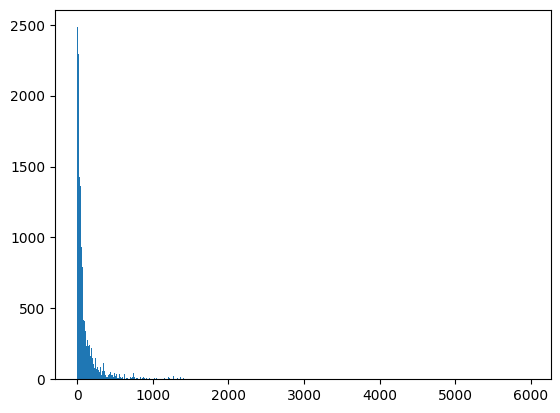

In [99]:
plt.hist(resolution_tags_df_sorted['original_polygons_avg_area_cm2'], bins = 500)
plt.show()

Optimization terminated successfully.
         Current function value: 0.596265
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.611964
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.580013
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.588177
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.608513
         Iterations 6


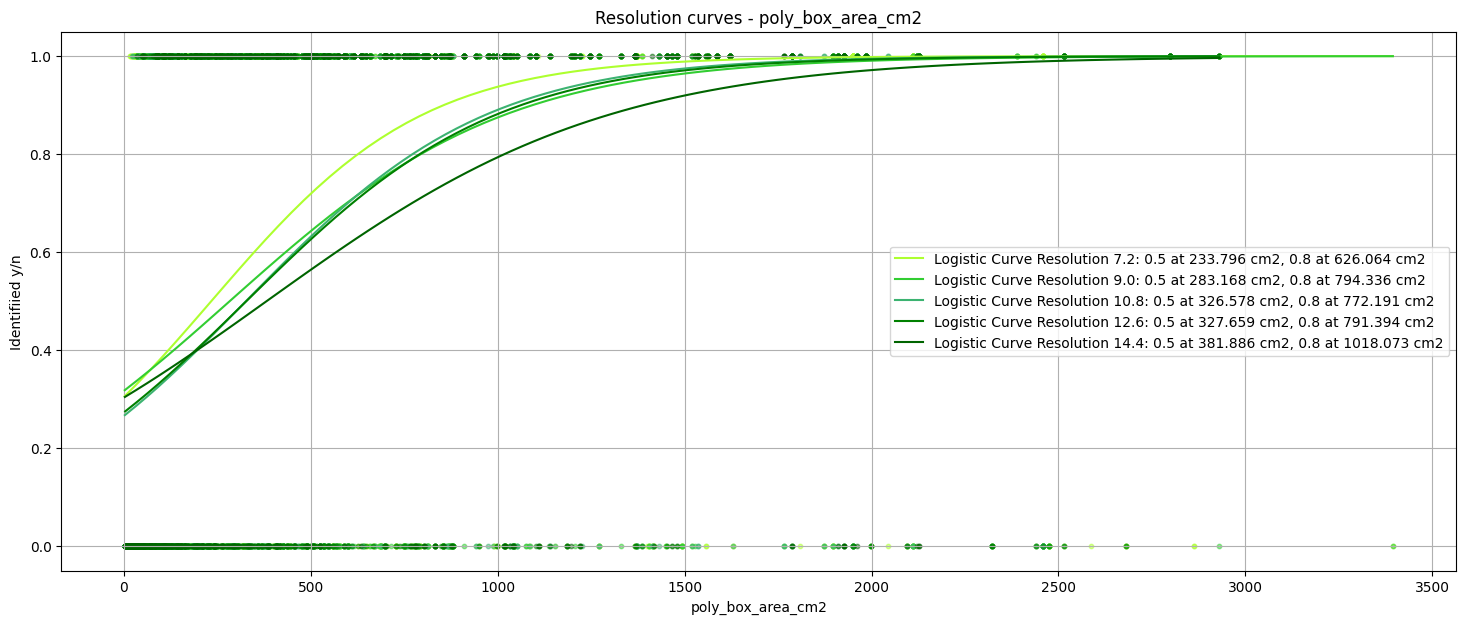

In [56]:
# PLOT THE GRAPHS ON TOP OF EACH OTHER

COLUMN_NAME = 'poly_box_area_cm2'
UNITS = COLUMN_NAME.split("_")[-1]
N = 8

resolutions = [7.2, 9.0, 10.8, 12.6, 14.4]
colors = ['violet', 'palevioletred', 'hotpink', 'mediumvioletred', 'darkred']
colors = ['greenyellow', 'limegreen', 'mediumseagreen', 'g', 'darkgreen']


def filter_df_by_mean_and_std(resolution_tags_df, column_name, n = 8):
    mean = resolution_tags_df[column_name].mean()
    std = resolution_tags_df[column_name].std()
    filter_threshold = mean + std * n
    df_filtered = resolution_tags_df[resolution_tags_df[column_name] <= filter_threshold]
    return df_filtered


# resolution_tags_df_filtered = resolution_tags_df_sorted[resolution_tags_df_sorted['original_polygons_avg_area_mm2']<=80000]
# resolution_tags_df_filtered = resolution_tags_df_sorted[resolution_tags_df_sorted['original_polygons_avg_area_m2']<=0.02]

resolution_tags_df_filtered = filter_df_by_mean_and_std(resolution_tags_df_sorted, column_name=COLUMN_NAME, n=N)

fig, ax = plt.subplots(figsize=(18, 7))

x_th_dict = {}

for i, resolution in enumerate(resolutions):
    zero_rows = resolution_tags_df_filtered[resolution_tags_df_filtered[f'res_{resolution}_binary'] == 0]
    one_rows = resolution_tags_df_filtered[resolution_tags_df_filtered[f'res_{resolution}_binary'] == 1]

    # Randomly choose the same number of zero rows as the number of one rows
    num_rows_to_choose = min(len(zero_rows), len(one_rows))
    chosen_zero_rows = zero_rows.sample(n=num_rows_to_choose, random_state=42)

    # Concatenate the chosen zero rows and one rows to create the balanced DataFrame
    balanced_df = pd.concat([chosen_zero_rows, one_rows])

    # # Shuffle the rows of the balanced DataFrame (optional)
    # balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

    data = {
        'x': balanced_df[COLUMN_NAME].values,
        'y': balanced_df[f'res_{resolution}_binary'].values,  # y values should be between 0 and 1 for logistic curve fitting
    }

    df = pd.DataFrame(data)

    # Add constant to the predictor variable for the logistic regression
    X = sm.add_constant(df['x'])

    # Fit the logistic regression model
    logit_model = sm.Logit(df['y'], X)
    result = logit_model.fit()

    # # Print the model summary
    # print(result.summary())

    # Get the fitted parameters
    params = result.params
    a_fit, b_fit = params

    # Generate the curve based on the fitted parameters
    x_curve = np.linspace(min(df['x']), max(df['x']), 100)
    # x_curve = np.linspace(-100, max(df['x']), 100)

    y_curve = 1 / (1 + np.exp(-params[0] - params[1] * x_curve))

    ax.scatter(df['x'], df['y'], color=colors[i], marker='o', alpha=0.5, s=10)
    x_th = -params[0] / params[1]
    
    res_x_th_dict = {}
    target_sigmoid_values = 0.5, 0.6, 0.7, 0.8, 0.9
    for t_value in target_sigmoid_values:
        res_x_th_dict[f"x_th_{t_value}"] = f"{int((-np.log((1-t_value) / t_value) - a_fit) / b_fit)}_{UNITS}"
    
    x_th_dict[f"resolution_{resolution}"] = res_x_th_dict
    
    
    target_sigmoid_value = 0.8
    x_th_0_8 = (-np.log((1-target_sigmoid_value) / target_sigmoid_value) - a_fit) / b_fit
    
    ax.plot(x_curve, y_curve, color=colors[i], label=f'Logistic Curve Resolution {resolution}: 0.5 at {"{:.3f}".format(x_th)} {UNITS}, 0.8 at {"{:.3f}".format(x_th_0_8)} {UNITS}')

ax.set_xlabel(COLUMN_NAME)
ax.set_ylabel(f'Identifiied y/n')
title = f'Resolution curves - {COLUMN_NAME}'
ax.set_title(title)
ax.legend()
ax.grid(True)
# plt.savefig(os.path.join(DATA_DIR, "resolution_test", title))
plt.show()

In [49]:
json_file_path = os.path.join(DATA_DIR, "resolution_test",  "resolution_limitation_results.json")

# Save the data to the JSON file
with open(json_file_path, "w") as json_file:
    json.dump(x_th_dict, json_file, indent=4)

In [ ]:
-params[0] / params[1]

In [ ]:


resolutions = [7.2, 9.0, 10.8, 12.6, 14.4]
colors = ['violet', 'palevioletred', 'hotpink', 'mediumvioletred', 'darkred']

resolution_tags_df_filtered = resolution_tags_df_sorted[resolution_tags_df_sorted['poly_box_length_mm']<=200]


for i, resolution in enumerate(resolutions):
    zero_rows = resolution_tags_df_filtered[resolution_tags_df_filtered[f'res_{resolution}_binary'] == 0]
    one_rows = resolution_tags_df_filtered[resolution_tags_df_filtered[f'res_{resolution}_binary'] == 1]

    # Randomly choose the same number of zero rows as the number of one rows
    num_rows_to_choose = min(len(zero_rows), len(one_rows))
    chosen_zero_rows = zero_rows.sample(n=num_rows_to_choose, random_state=42)

    # Concatenate the chosen zero rows and one rows to create the balanced DataFrame
    balanced_df = pd.concat([chosen_zero_rows, one_rows])

    # # Shuffle the rows of the balanced DataFrame (optional)
    # balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

    data = {
        'x': balanced_df['poly_box_length_mm'].values,
        'y': balanced_df[f'res_{resolution}_binary'].values,  # y values should be between 0 and 1 for logistic curve fitting
    }

    df = pd.DataFrame(data)

    # Add constant to the predictor variable for the logistic regression
    X = sm.add_constant(df['x'])

    # Fit the logistic regression model
    logit_model = sm.Logit(df['y'], X)
    result = logit_model.fit()

    # # Print the model summary
    print(result.summary())

    # Get the fitted parameters
    params = result.params
    a_fit, b_fit = params

    # Generate the curve based on the fitted parameters
    x_curve = np.linspace(min(df['x']), max(df['x']), 100)
    y_curve = 1 / (1 + np.exp(-params[0] - params[1] * x_curve))

    # Plot the original data points and the fitted logistic curve
    plt.figure(figsize=(18, 7))
    plt.scatter(df['x'], df['y'], label='Data', color="black", marker='o', alpha=0.5, s=10)
    plt.plot(x_curve, y_curve, color=colors[i], label=f'Logistic Curve Resolution {resolution}')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'res_{resolution}')
    plt.legend()
    plt.grid(True)
plt.show()

In [ ]:
# resolution_tags_df['poly_union_area_pixel']
# resolution_tags_df['res_7.2']

resolution_tags_df_sorted = resolution_tags_df.sort_values(by='poly_union_area_pixel')

resolution_tags_df_sorted['res_7.2_binary'] = resolution_tags_df_sorted['res_7.2'].apply(lambda x: 1 if x > 0 else 0)
resolution_tags_df_sorted['res_9.0_binary'] = resolution_tags_df_sorted['res_9.0'].apply(lambda x: 1 if x > 0 else 0)
resolution_tags_df_sorted['res_10.8_binary'] = resolution_tags_df_sorted['res_10.8'].apply(lambda x: 1 if x > 0 else 0)
resolution_tags_df_sorted['res_12.6_binary'] = resolution_tags_df_sorted['res_12.6'].apply(lambda x: 1 if x > 0 else 0)
resolution_tags_df_sorted['res_14.4_binary'] = resolution_tags_df_sorted['res_14.4'].apply(lambda x: 1 if x > 0 else 0)


plt.figure(figsize=(18, 7))
plt.scatter(resolution_tags_df_sorted['poly_box_length_mm'], resolution_tags_df_sorted['res_14.4_binary'], marker='o', alpha=0.5, s=10)
# plt.plot(resolution_tags_df['res_7.2'])

# Add labels and title (optional)
# plt.xlim(100, 20000)
# plt.xlim(15000, 30000)

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Plotting a Curve')

# Show the plot
plt.show()


In [ ]:
example_zoom_image_id = env.eti_api.get_matching_zoom_images([5372412])[0]
example_zoom_image_id

In [ ]:
example_zoom_image_id

# Read points tags dataframe

In [128]:
false_alarm_rate

0.08318345323741007

In [132]:
resolution_tags_df_sorted.columns

Index(['Unnamed: 0', 'original_polygons', 'poly_intersection',
       'overlapping_polygons_indexes', 'original_polygons_avg_area_pixel',
       'original_polygons_avg_length_mm', 'original_polygons_avg_area_mm2',
       'num_of_original_polygons', 'poly_union', 'poly_union_area_pixel',
       'poly_union_length_mm', 'poly_union_area_mm2', 'poly_iou', 'poly_box',
       'poly_box_area_pixel', 'poly_box_length_mm', 'poly_box_area_mm2',
       'annotators', 'image_id', 'res_7.2', 'res_9.0', 'res_10.8', 'res_12.6',
       'res_14.4', 'original_polygons_avg_area_m2', 'poly_union_area_m2',
       'poly_box_area_m2', 'original_polygons_avg_area_cm2',
       'poly_union_area_cm2', 'poly_box_area_cm2', 'res_7.2_binary',
       'res_9.0_binary', 'res_10.8_binary', 'res_12.6_binary',
       'res_14.4_binary'],
      dtype='object')

In [48]:
DIST_TH_PX = 30

points_tags_df = pd.read_csv(os.path.join(DATA_DIR, "resolution_limitation_points_tags_df_5.csv"))
points_tags_df['soft_is_included'] = points_tags_df.apply(lambda row: True if row['is_included'] == True or row['distance_to_closest_polygon'] <= DIST_TH_PX else False, axis=1)
false_alarm_rate = points_tags_df['soft_is_included'].value_counts()[False] / len(points_tags_df)

print(f"len points_tags_df: {len(points_tags_df)}")
print(f"Unique image ids in points_tags df: {len(np.unique(points_tags_df['image_id']))}")
print(f"Num of points not included in a polygon {points_tags_df['is_included'].value_counts()[False]}")
print(f"Num of points not included in a polygon (soft - {DIST_TH_PX} pixel distance from polygons): {points_tags_df['soft_is_included'].value_counts()[False]}")
print(f"False alarm rate (soft): {int(false_alarm_rate*100)}%")

results_dictionary = {f"len points_tags_df": f"{len(points_tags_df)}",
                      f"Unique image ids in points_tags df": f"{len(np.unique(points_tags_df['image_id']))}",
                      f"Num of points not included in a polygon": f"{points_tags_df['is_included'].value_counts()[False]}",
                      f"Num of points not included in a polygon (soft - {DIST_TH_PX} pixel distance from polygons)": f"{points_tags_df['soft_is_included'].value_counts()[False]}",
                      f"False alarm rate (soft)": f"{int(false_alarm_rate*100)}%"}



# len(points_tags_df), len(np.unique(points_tags_df['image_id'])), len(np.unique(points_tags_df['resolution'])), points_tags_df['is_included'].value_counts()[False], points_tags_df['soft_is_included'].value_counts()[False]

len points_tags_df: 2224
Unique image ids in points_tags df: 490
Num of points not included in a polygon 224
Num of points not included in a polygon (soft - 30 pixel distance from polygons): 185
False alarm rate (soft): 8%


In [50]:
# SAVE RESULTS TO EXISTING JSON FILE
json_file_path = json_file_path

# Read the existing JSON file and load its contents
with open(json_file_path, "r") as json_file:
    existing_data = json.load(json_file)

# Merge the new dictionary with the loaded data
existing_data.update(results_dictionary)

# Write the merged data back to the JSON file
with open(json_file_path, "w") as json_file:
    json.dump(existing_data, json_file, indent=4)

# Analyze false alarm points

In [4]:
false_alarm_points_df = points_tags_df[points_tags_df['soft_is_included']==False].reset_index(drop=True)
len(np.unique(false_alarm_points_df['image_id'])), len(false_alarm_points_df)

fa_image_ids = false_alarm_points_df['image_id'].values

In [52]:
# CALCULATE FALSE ALARM RATE FOR EACH RESOLUTION

far_per_resolution_dict = {}
resolutions, resolution_counts = np.unique(points_tags_df['resolution'], return_counts=True)
for i, res in enumerate(resolutions):
    far_per_resolution_dict[f"res_{res}_far"] = f"{int(100 * len(false_alarm_points_df[false_alarm_points_df['resolution'] == res])/resolution_counts[i])}%"

far_per_resolution_dict

{'res_7.2_far': '6%',
 'res_9.0_far': '8%',
 'res_10.8_far': '7%',
 'res_12.6_far': '9%',
 'res_14.4_far': '12%'}

In [53]:
# SAVE RESULTS TO EXISTING JSON FILE
json_file_path = json_file_path

# Read the existing JSON file and load its contents
with open(json_file_path, "r") as json_file:
    existing_data = json.load(json_file)

# Merge the new dictionary with the loaded data
existing_data.update(far_per_resolution_dict)

# Write the merged data back to the JSON file
with open(json_file_path, "w") as json_file:
    json.dump(existing_data, json_file, indent=4)

In [119]:
small_dist_from_polygons = false_alarm_points[false_alarm_points['distance_to_closest_polygon']<=40]
# small_dist_from_polygons = small_dist_from_polygons[small_dist_from_polygons['distance_to_closest_polygon']>=20]
small_dist_from_polygons['image_id'].values
# len(small_dist_from_polygons)

array([], dtype=int64)

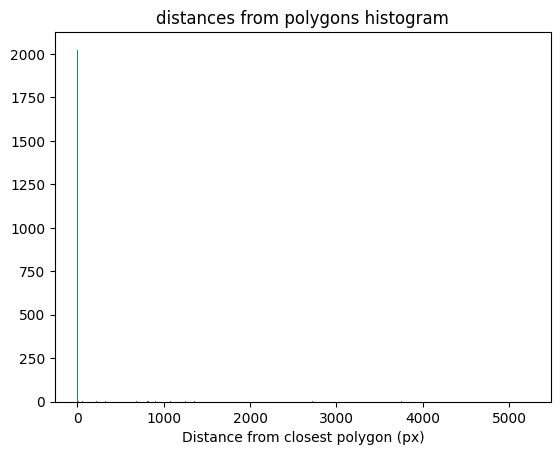

In [130]:
# plt.hist(points_tags_df['distance_to_closest_polygon'], bins=1000)
# plt.xlim(0, 100)
plt.title("distances from polygons histogram")
plt.xlabel('Distance from closest polygon (px)')
plt.show()

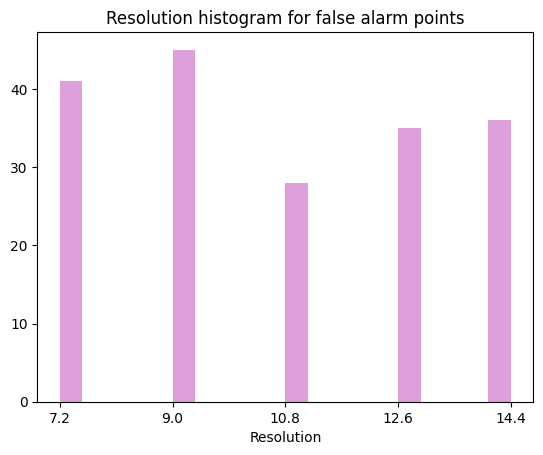

In [55]:
res_options = np.unique(points_tags_df['resolution'])

plt.hist(false_alarm_points_df['resolution'], color = 'plum', bins = 20)
# plt.savefig(os.path.join(DATA_DIR, "resolution_test", f'Resolution_histogram_for_false_alarm_points.png'))
plt.xticks(res_options)
plt.title("Resolution histogram for false alarm points")
plt.xlabel('Resolution')
plt.show()